In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
from scipy import integrate
from mpl_toolkits.mplot3d import Axes3D

dt = 0.01
T = 8
t = np.arange(0,T+dt,dt)
beta = 8/3
sigma = 10
rho = [10, 17, 28, 35, 40]

def lorenz_deriv(x_y_z, t0, sigma=sigma, beta=beta, rho=rho[0]):
    x, y, z = x_y_z
    return [sigma * (y - x), x * (rho - z) - y, x * y - beta * z]

np.random.seed(123)
x0 = -15 + 30 * np.random.random((100, 3))

x_t = []
for i in range(5):
  x_t_part = np.asarray([integrate.odeint(lorenz_deriv, x0_j, t, args=(sigma, beta, rho[i]))
                  for x0_j in x0])
  x_t.append(x_t_part)

print(np.array(x_t).shape)

(5, 100, 801, 3)


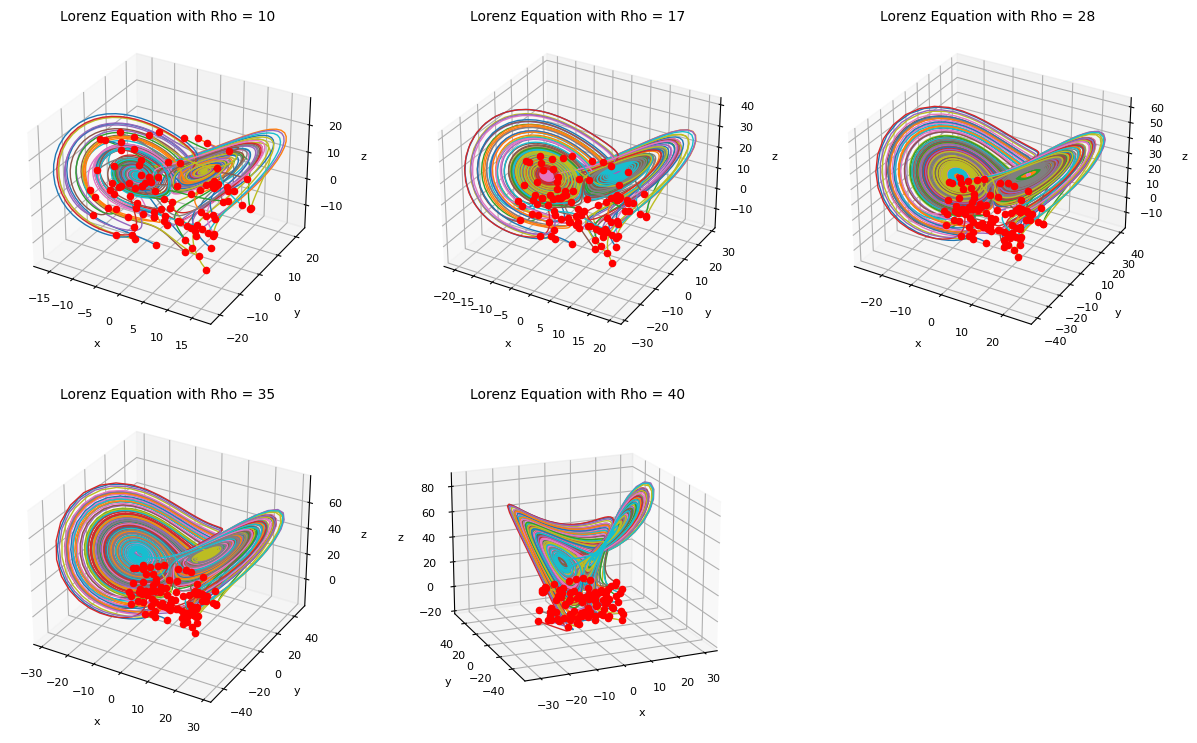

In [3]:
nn_input = np.zeros((80000 * 5, 3))
nn_output = np.zeros((80000 * 5, 3))

fig = plt.figure(figsize=(15, 9))

for k in range(5):
  x_t_current = x_t[k]
  input = np.zeros((100*(len(t)-1),3))
  output = np.zeros_like(input)

  ax = fig.add_subplot(2, 3, k + 1, projection='3d')
  for j in range(100):
    
    input[j*(len(t)-1):(j+1)*(len(t)-1),:] = x_t_current[j,:-1,:]
    output[j*(len(t)-1):(j+1)*(len(t)-1),:] = x_t_current[j,1:,:]
    
    x, y, z = x_t_current[j,:,:].T

    ax.plot(x, y, z,linewidth=1)
    ax.scatter(x0[j,0],x0[j,1],x0[j,2],color='r')
    
    
  nn_input[k * 80000: (k + 1)  * 80000] = input
  nn_output[k * 80000: (k + 1)  * 80000] = output

  ax.set_title('Lorenz Equation with Rho = ' + str(rho[k]), fontsize=10)
  ax.set_xlabel('x', fontsize=8)
  ax.set_ylabel('y', fontsize=8)
  ax.set_zlabel('z', fontsize=8)  
  ax.tick_params(axis='both', which='major', labelsize=8)
  ax.tick_params(axis='both', which='minor', labelsize=7)
ax.view_init(18, -113)
plt.show()

nn_input = np.array(nn_input)
nn_output = np.array(nn_output)

In [4]:
print(nn_input.shape)
print(nn_output.shape)

(400000, 3)
(400000, 3)


In [5]:
X_train = np.concatenate((nn_input[0:80000], nn_input[80000 * 2: 80000 * 3], nn_input[80000 * 4: 80000 * 5]))
X_test = np.concatenate((nn_input[80000:80000 * 2], nn_input[80000 * 3:80000 * 4]))

Y_train = np.concatenate((nn_output[0:80000], nn_output[80000 * 2: 80000 * 3], nn_output[80000 * 4: 80000 * 5]))
Y_test = np.concatenate((nn_output[80000:80000 * 2], nn_output[80000 * 3:80000 * 4]))

In [6]:
print(X_train.shape)
print(X_test.shape)

(240000, 3)
(160000, 3)


In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

dataset_train = torch.utils.data.TensorDataset(torch.tensor(X_train), torch.tensor(Y_train)) # create datset
dataset_test = torch.utils.data.TensorDataset(torch.tensor(X_test), torch.tensor(Y_test))

dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=64, shuffle=True) # create dataloader
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=64, shuffle=False)

In [27]:
# Define activation functions
def logsig(x):
    return 1 / (1 + torch.exp(-x))

def radbas(x):
    return torch.exp(-torch.pow(x, 2))

def purelin(x):
    return x

# Define the model
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.fc1 = nn.Linear(in_features=3, out_features=10)
        self.fc2 = nn.Linear(in_features=10, out_features=10)
        self.fc3 = nn.Linear(in_features=10, out_features=3)
        self.m = nn.ReLU()
        
    def forward(self, x):
        x = self.m(self.fc1(x))
        x = self.m(self.fc2(x))
        x = purelin(self.fc3(x))
        return x

# Create model instance
model = MyModel()

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
for epoch in range(10):
    optimizer.zero_grad()

    for i, data in enumerate(dataloader_train):
      x, y = data
      outputs = model(x.float())
      loss = criterion(outputs, y.float())
      loss.backward()
      optimizer.step()
      if (i+1) % 500 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch + 1, 10, i+1, len(dataloader_train), loss.item()))

nn_normal = np.zeros((160000, 3))

with torch.no_grad():
    total = 0.0
    for i, data in enumerate(dataloader_test):
      x, y = data
      outputs = model(x.float())
      MSE = (outputs - y.float())**2
      total += MSE
      nn_normal[i * 64:(i + 1) * 64] = outputs.numpy()
    print('MSE Error: {}'.format(torch.mean(total)))


Epoch [1/10], Step [500/3750], Loss: 54.7094
Epoch [1/10], Step [1000/3750], Loss: 47.8244
Epoch [1/10], Step [1500/3750], Loss: 92.7110
Epoch [1/10], Step [2000/3750], Loss: 94.7665
Epoch [1/10], Step [2500/3750], Loss: 87.5269
Epoch [1/10], Step [3000/3750], Loss: 84.5622
Epoch [1/10], Step [3500/3750], Loss: 83.3200
Epoch [2/10], Step [500/3750], Loss: 49.8562
Epoch [2/10], Step [1000/3750], Loss: 77.1552
Epoch [2/10], Step [1500/3750], Loss: 78.9124
Epoch [2/10], Step [2000/3750], Loss: 83.1528
Epoch [2/10], Step [2500/3750], Loss: 73.0761
Epoch [2/10], Step [3000/3750], Loss: 68.2479
Epoch [2/10], Step [3500/3750], Loss: 80.5263
Epoch [3/10], Step [500/3750], Loss: 75.5350
Epoch [3/10], Step [1000/3750], Loss: 59.5149
Epoch [3/10], Step [1500/3750], Loss: 63.7693
Epoch [3/10], Step [2000/3750], Loss: 53.3499
Epoch [3/10], Step [2500/3750], Loss: 94.5150
Epoch [3/10], Step [3000/3750], Loss: 74.9719
Epoch [3/10], Step [3500/3750], Loss: 83.7556
Epoch [4/10], Step [500/3750], Loss: 

In [8]:
def graph(array, color):
  for j in range(100):
    x_t_current[j,1:,:] = array[j*(len(t)-1):(j+1)*(len(t)-1),:]
    x, y, z = x_t_current[j,:,:].T
    ax.plot(x, y, z,linewidth=1, color=color)

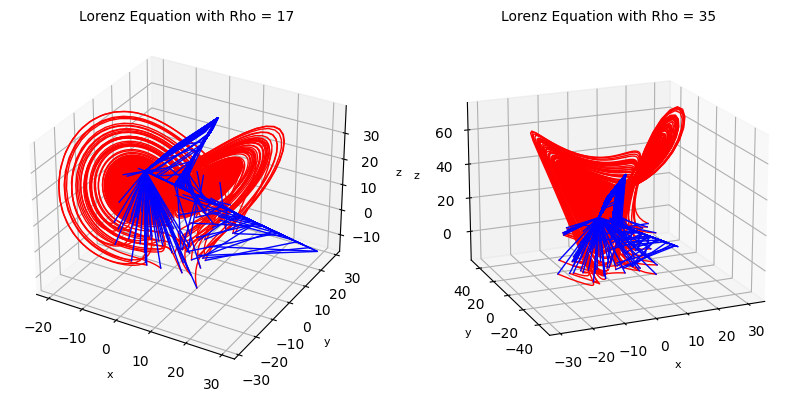

In [28]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 2, 1, projection='3d')
graph(Y_test[0:80000], 'r')
graph(nn_normal[0:80000], 'b')

ax.set_title('Lorenz Equation with Rho = ' + str(rho[1]), fontsize=10)
ax.set_xlabel('x', fontsize=8)
ax.set_ylabel('y', fontsize=8)
ax.set_zlabel('z', fontsize=8)  

ax = fig.add_subplot(1, 2, 2, projection='3d')
graph(Y_test[80000:160000], 'r')
graph(nn_normal[80000:160000], 'b')

ax.set_title('Lorenz Equation with Rho = ' + str(rho[3]), fontsize=10)
ax.set_xlabel('x', fontsize=8)
ax.set_ylabel('y', fontsize=8)
ax.set_zlabel('z', fontsize=8)  

ax.view_init(18, -113)
plt.show()

In [29]:
# Define the model
class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()
        self.rnn = nn.RNN(3, 10, 2, batch_first=True)
        self.fc = nn.Linear(10, 3)
        
    def forward(self, x):
        h0 = torch.zeros(2, 10)
        x, hidden = self.rnn(x, h0)
        x = self.fc(x)
        return x

# Create model instance
model = RNN()

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
for epoch in range(10):
    optimizer.zero_grad()

    for i, data in enumerate(dataloader_train):
      x, y = data
      outputs = model(x.float())
      loss = criterion(outputs, y.float())
      loss.backward()
      optimizer.step()
      if (i+1) % 500 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch + 1, 10, i+1, len(dataloader_train), loss.item()))

nn_RNN = np.zeros((160000, 3))

with torch.no_grad():
    total = 0.0
    for i, data in enumerate(dataloader_test):
      x, y = data
      outputs = model(x.float())
      MSE = (outputs - y.float())**2
      total += MSE

      nn_RNN[i * 64:(i + 1) * 64] = outputs.numpy()
        
    print('MSE Error: {}'.format(torch.mean(total)))

Epoch [1/10], Step [500/3750], Loss: 190.0366
Epoch [1/10], Step [1000/3750], Loss: 81.4088
Epoch [1/10], Step [1500/3750], Loss: 90.0879
Epoch [1/10], Step [2000/3750], Loss: 72.6901
Epoch [1/10], Step [2500/3750], Loss: 79.9569
Epoch [1/10], Step [3000/3750], Loss: 100.5669
Epoch [1/10], Step [3500/3750], Loss: 88.4941
Epoch [2/10], Step [500/3750], Loss: 80.4660
Epoch [2/10], Step [1000/3750], Loss: 38.3583
Epoch [2/10], Step [1500/3750], Loss: 38.9680
Epoch [2/10], Step [2000/3750], Loss: 35.1716
Epoch [2/10], Step [2500/3750], Loss: 57.4870
Epoch [2/10], Step [3000/3750], Loss: 39.3293
Epoch [2/10], Step [3500/3750], Loss: 35.7560
Epoch [3/10], Step [500/3750], Loss: 33.1470
Epoch [3/10], Step [1000/3750], Loss: 49.7231
Epoch [3/10], Step [1500/3750], Loss: 27.9788
Epoch [3/10], Step [2000/3750], Loss: 38.9867
Epoch [3/10], Step [2500/3750], Loss: 27.5098
Epoch [3/10], Step [3000/3750], Loss: 40.2395
Epoch [3/10], Step [3500/3750], Loss: 24.0777
Epoch [4/10], Step [500/3750], Loss

In [30]:
# Define the model
class LSTM(nn.Module):
    def __init__(self):
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(3, 10, 2, batch_first=True)
        self.fc = nn.Linear(10, 3)
        
    def forward(self, x):
        h0 = torch.zeros(2, 10)
        c0 = torch.zeros(2, 10)
        x, hidden = self.lstm(x, (h0, c0))
        x = self.fc(x)
        return x

# Create model instance
model = LSTM()

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
for epoch in range(10):
    optimizer.zero_grad()

    for i, data in enumerate(dataloader_train):
      x, y = data
      outputs = model(x.float())
      loss = criterion(outputs, y.float())
      loss.backward()
      optimizer.step()
      if (i+1) % 500 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch + 1, 10, i+1, len(dataloader_train), loss.item()))

nn_LSTM = np.zeros((160000, 3))
with torch.no_grad():
    total = 0.0
    for i, data in enumerate(dataloader_test):
      x, y = data
      outputs = model(x.float())
      MSE = (outputs - y.float())**2
      total += MSE

      nn_LSTM[i * 64:(i + 1) * 64] = outputs.numpy()
        
    print('MSE Error: {}'.format(torch.mean(total)))

Epoch [1/10], Step [500/3750], Loss: 149.0053
Epoch [1/10], Step [1000/3750], Loss: 96.8955
Epoch [1/10], Step [1500/3750], Loss: 126.4300
Epoch [1/10], Step [2000/3750], Loss: 158.3271
Epoch [1/10], Step [2500/3750], Loss: 186.6631
Epoch [1/10], Step [3000/3750], Loss: 160.6868
Epoch [1/10], Step [3500/3750], Loss: 137.3153
Epoch [2/10], Step [500/3750], Loss: 139.5440
Epoch [2/10], Step [1000/3750], Loss: 107.4602
Epoch [2/10], Step [1500/3750], Loss: 137.4234
Epoch [2/10], Step [2000/3750], Loss: 142.3721
Epoch [2/10], Step [2500/3750], Loss: 115.5725
Epoch [2/10], Step [3000/3750], Loss: 106.5684
Epoch [2/10], Step [3500/3750], Loss: 134.4876
Epoch [3/10], Step [500/3750], Loss: 96.5583
Epoch [3/10], Step [1000/3750], Loss: 92.1995
Epoch [3/10], Step [1500/3750], Loss: 127.0415
Epoch [3/10], Step [2000/3750], Loss: 112.7595
Epoch [3/10], Step [2500/3750], Loss: 108.7143
Epoch [3/10], Step [3000/3750], Loss: 128.2437
Epoch [3/10], Step [3500/3750], Loss: 119.2153
Epoch [4/10], Step 

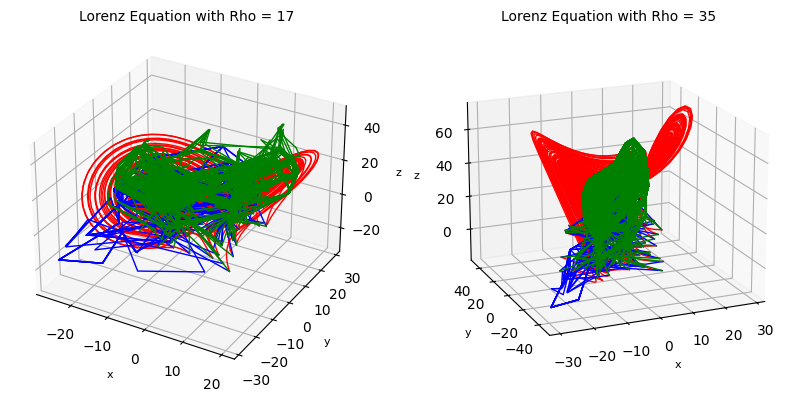

In [31]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 2, 1, projection='3d')
graph(Y_test[0:80000], 'r')
graph(nn_RNN[0:80000], 'b')
graph(nn_LSTM[0:80000], 'g')

ax.set_title('Lorenz Equation with Rho = ' + str(rho[1]), fontsize=10)
ax.set_xlabel('x', fontsize=8)
ax.set_ylabel('y', fontsize=8)
ax.set_zlabel('z', fontsize=8)  

ax = fig.add_subplot(1, 2, 2, projection='3d')
graph(Y_test[80000:160000], 'r')
graph(nn_RNN[80000:160000], 'b')
graph(nn_LSTM[80000:160000], 'g')

ax.set_title('Lorenz Equation with Rho = ' + str(rho[3]), fontsize=10)
ax.set_xlabel('x', fontsize=8)
ax.set_ylabel('y', fontsize=8)
ax.set_zlabel('z', fontsize=8)  

ax.view_init(18, -113)
plt.show()

In [ ]:
pip install auto_esn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached auto_esn-0.0.7-py3-none-any.whl (295 kB)
  Using cached numpy-1.20.2.zip (7.8 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached pandas-1.2.4.tar.gz (5.5 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached matplotlib-3.4.2-cp310-cp310-linux_x86_64.whl
  Using cached networkx-2.5.1-py3-none-any.whl (1.6 MB)
  error: subprocess-exited-with-error
  
  × Building wheel for numpy (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for numpy
ERROR: Operation cancelled by user


In [14]:
from auto_esn.esn.esn import GroupedDeepESN
import torch.nn as nn
import torch.optim as optim

esn = GroupedDeepESN(input_size=3, groups=4, num_layers=(2, 2), hidden_size=10, output_dim=3)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(esn.parameters(), lr=0.001)

# Train the model
for epoch in range(10):
    optimizer.zero_grad()

    for i, data in enumerate(dataloader_train):
      x, y = data
      outputs = esn(x.float())
      loss = criterion(outputs, y.float())
      loss.backward()
      optimizer.step()
      if (i+1) % 500 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch + 1, 10, i+1, len(dataloader_train), loss.item()))

nn_ESN = np.zeros((160000, 3))

with torch.no_grad():
    total = 0.0
    for i, data in enumerate(dataloader_test):
      x, y = data
      outputs = esn(x.float())
      MSE = (outputs - y.float())**2
      total += MSE

    nn_ESN[i * 64:(i + 1) * 64] = outputs.numpy()
        
    print('MSE Error: {}'.format(torch.mean(total)))

Epoch [1/10], Step [500/3750], Loss: 4930.0483
Epoch [1/10], Step [1000/3750], Loss: 8698.0928
Epoch [1/10], Step [1500/3750], Loss: 16686.6191
Epoch [1/10], Step [2000/3750], Loss: 10585.1338
Epoch [1/10], Step [2500/3750], Loss: 17025.1309
Epoch [1/10], Step [3000/3750], Loss: 11378.6406
Epoch [1/10], Step [3500/3750], Loss: 24955.8906
Epoch [2/10], Step [500/3750], Loss: 7436.9141
Epoch [2/10], Step [1000/3750], Loss: 2345.2825
Epoch [2/10], Step [1500/3750], Loss: 8771.0244
Epoch [2/10], Step [2000/3750], Loss: 12839.1719
Epoch [2/10], Step [2500/3750], Loss: 15330.6260
Epoch [2/10], Step [3000/3750], Loss: 20427.0410
Epoch [2/10], Step [3500/3750], Loss: 28123.4473
Epoch [3/10], Step [500/3750], Loss: 5179.8789
Epoch [3/10], Step [1000/3750], Loss: 13235.4336
Epoch [3/10], Step [1500/3750], Loss: 16196.2588
Epoch [3/10], Step [2000/3750], Loss: 8602.9600
Epoch [3/10], Step [2500/3750], Loss: 6406.1460
Epoch [3/10], Step [3000/3750], Loss: 11314.3086
Epoch [3/10], Step [3500/3750],

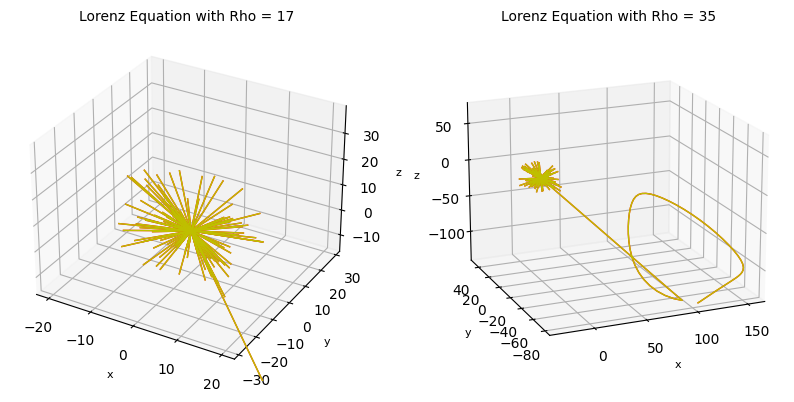

In [17]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 2, 1, projection='3d')
graph(Y_test[0:80000], 'r')
graph(nn_ESN[0:80000], 'y')

ax.set_title('Lorenz Equation with Rho = ' + str(rho[1]), fontsize=10)
ax.set_xlabel('x', fontsize=8)
ax.set_ylabel('y', fontsize=8)
ax.set_zlabel('z', fontsize=8)  

ax = fig.add_subplot(1, 2, 2, projection='3d')
graph(Y_test[80000:160000], 'r')
graph(nn_ESN[80000:160000], 'y')

ax.set_title('Lorenz Equation with Rho = ' + str(rho[3]), fontsize=10)
ax.set_xlabel('x', fontsize=8)
ax.set_ylabel('y', fontsize=8)
ax.set_zlabel('z', fontsize=8)  

ax.view_init(18, -113)
plt.show()